<a href="https://colab.research.google.com/github/reinaldogpn/coffee-classification-research/blob/main/08_new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup**

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    ds_path = '/content/drive/MyDrive/Iniciação Científica - FAPEMIG 2022/classifier-trainingdata.zip'
    zip_object = zipfile.ZipFile(file = ds_path, mode = 'r')
    zip_object.extractall('./')
    zip_object.close()

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Finetuning Torchvision Models**

In [ ]:
# from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

import time
import os
import copy
import random
import csv
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import metrics
from PIL import Image

from __future__ import print_function
from __future__ import division

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.utils import make_grid

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

#%matplotlib notebook

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


### **Detectando se há uma GPU disponível**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Device: {device}')
print(device.type)

Device: cuda:0
cuda


In [ ]:
!nvidia-smi

Tue Jun  6 17:44:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Configurações para reprodutibilidade**

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### **Definindo hiperparâmetros**

In [ ]:
# [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Número de classes
num_classes = 2

# Tamanho do lote (mini-batch)
batch_size = 64

# Número de épocas
num_epochs = 100

# Learning rate:
lr = 0.1

# Momentum:
mm = 0.9

feature_extract = True

## **O conjunto de dados**

### **Caminho para as pastas (treino e teste)**

In [ ]:
if IN_COLAB:
    data_dir = "/content/classifier-trainingdata"
else:
    data_dir = "../Datasets/classifier-trainingdata"

### **Preparando o conjunto de dados**

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.385, 0.385, 0.385], [0.4, 0.395, 0.396])
    ])

full_dataset = datasets.ImageFolder(data_dir, transform = data_transforms)

### **Visualizando Amostras do Dataset**

In [ ]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

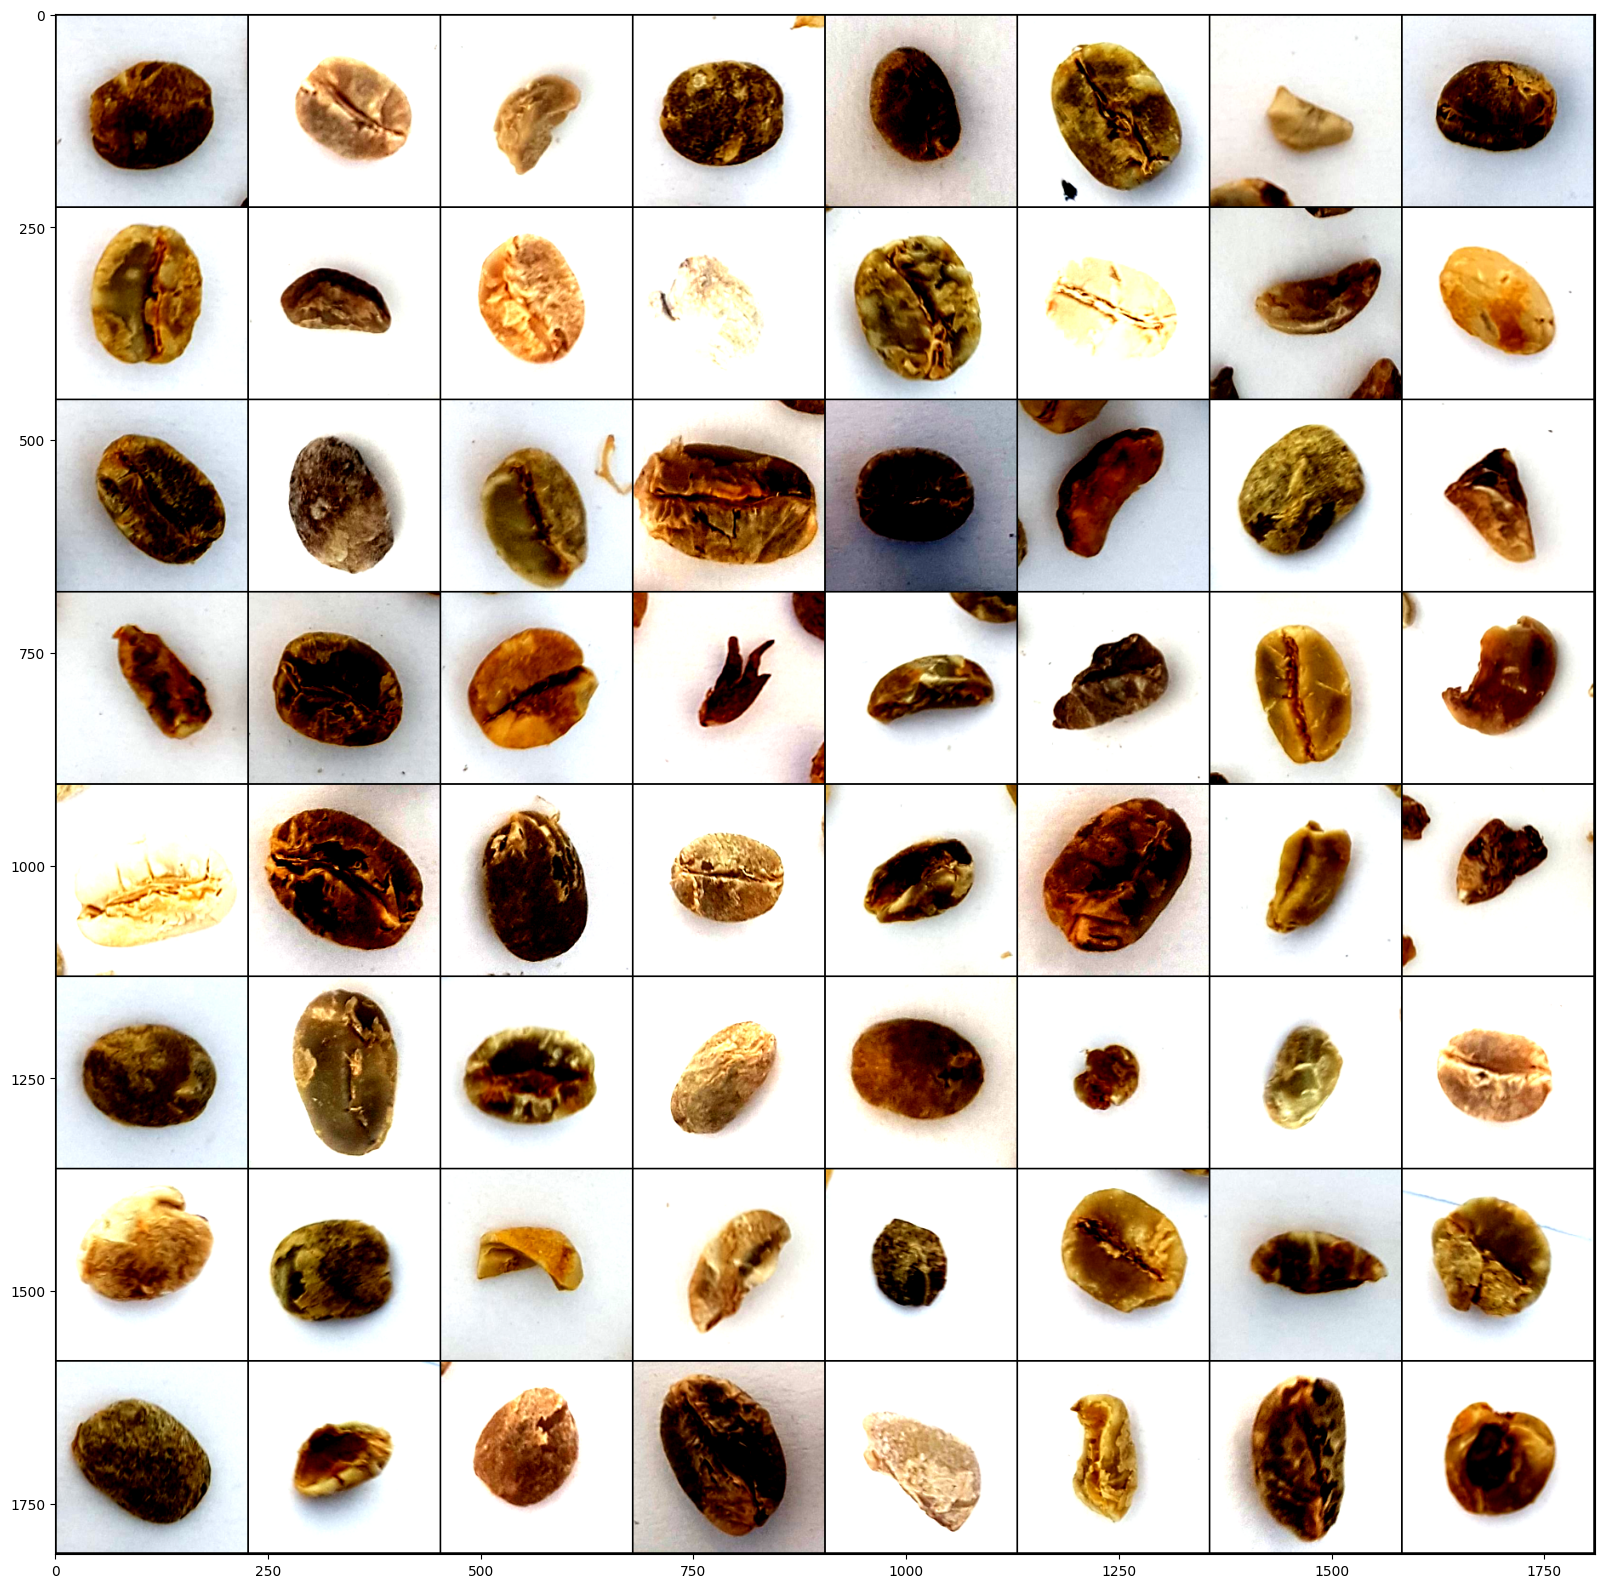

In [ ]:
vis_dataset_loader = DataLoader(dataset=full_dataset, shuffle=True, batch_size=batch_size)

items = iter(vis_dataset_loader)
image, label = next(items)

show_transformed_image(make_grid(image))

### **Dividindo o conjunto de treino em treino/validação**

In [ ]:
# Lista de classes
classes_list = os.listdir(data_dir)

print(f'Classes: {classes_list}')

# Conjunto de treinamento: 80%
train_size = int(0.8 * len(full_dataset))

# Conjunto de validação: 20%
val_size = len(full_dataset) - train_size

# Spliting the full dataset
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Número de imagens em cada dataset
train_size = len(train_dataset)
val_size = len(val_dataset)

# print(train_size)
# print(val_size)

# Definindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

Classes: ['bad', 'good']


## **Modelo de Treinamento e Validação**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=False):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
              val_acc = torch.sum(preds == labels.data)
              val_acc_history.append(epoch_acc)
            if phase == 'train':
              train_acc = torch.sum(preds == labels.data)
              train_acc_history.append(train_acc.double() / batch_size)
#            if phase == 'val':
#                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model, train_acc_history, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### **Inicializando e Remodulando a CNN**

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(weights='AlexNet_Weights.DEFAULT')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(weights='VGG11_BN_Weights.DEFAULT')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(weights='SqueezeNet1_0_Weights.DEFAULT')
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')
        set_parameter_requires_grad(model_ft, feature_extract)

        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### **Otimizador**

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=mm)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


### **Treinando e Validando o Modelo**

In [ ]:
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/99
----------
train Loss: 23.5130 Acc: 0.7535
val Loss: 10.1911 Acc: 0.8477

Epoch 1/99
----------
train Loss: 20.7277 Acc: 0.7835
val Loss: 8.9302 Acc: 0.8758

Epoch 2/99
----------
train Loss: 15.8831 Acc: 0.8127
val Loss: 8.6524 Acc: 0.8564

Epoch 3/99
----------
train Loss: 19.0950 Acc: 0.8011
val Loss: 40.2452 Acc: 0.7257

Epoch 4/99
----------
train Loss: 12.9492 Acc: 0.8232
val Loss: 8.7087 Acc: 0.8575

Epoch 5/99
----------
train Loss: 16.0434 Acc: 0.7946
val Loss: 10.4754 Acc: 0.8240

Epoch 6/99
----------
train Loss: 23.6091 Acc: 0.7886
val Loss: 12.5776 Acc: 0.8596

Epoch 7/99
----------
train Loss: 19.8877 Acc: 0.8116
val Loss: 29.0304 Acc: 0.7981

Epoch 8/99
----------
train Loss: 13.0750 Acc: 0.8349
val Loss: 20.5950 Acc: 0.7894

Epoch 9/99
----------
train Loss: 13.8718 Acc: 0.8165
val Loss: 32.6802 Acc: 0.7441

Epoch 10/99
----------
train Loss: 18.5495 Acc: 0.8051
val Loss: 8.1770 Acc: 0.8812

Epoch 11/99
----------
train Loss: 12.0981 Acc: 0.8376
val Loss: 8.1

### **Plotando gráfico de acurácia por época**

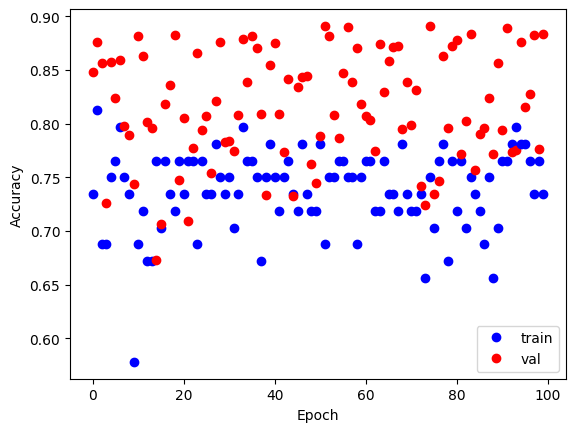

In [ ]:
train_hist_cpu = [x.cpu() for x in train_hist]
val_hist_cpu = [x.cpu() for x in val_hist]

#plt.plot(range(num_epochs), train_hist_cpu, label='train')
#plt.plot(range(num_epochs), val_hist_cpu, label='val')

for i in range(len(train_hist_cpu)):
    plt.plot([i], [train_hist_cpu[i]], 'bo')
    plt.plot([i], [val_hist_cpu[i]], 'ro')

plt.legend(['train', 'val'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## **Matriz de confusão e relatório de treinamento**

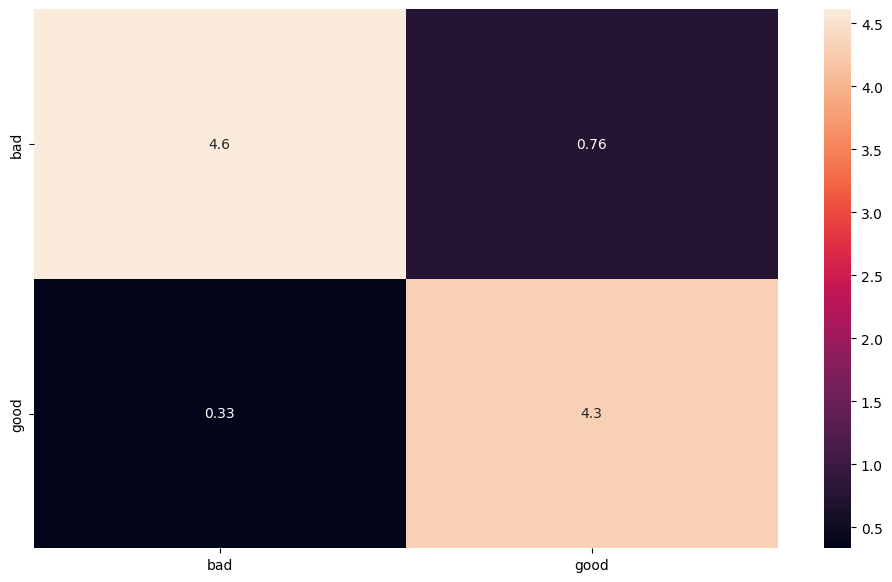

In [ ]:
# caminho do diretório onde os resultados serão salvos

if IN_COLAB:
    result_path = '/content/drive/MyDrive/Iniciação Científica - FAPEMIG 2022/Results'
else:
    result_path = "../results"

y_pred = []
y_true = []

for inputs, labels in val_dataloader:
    if device.type == 'cuda':
        inputs = inputs.to(device)
        labels = labels.to(device)

        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = metrics.confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes_list],
                     columns = [i for i in classes_list])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig(os.path.join(result_path, 'output.png'))

In [ ]:
# Confusion matrix
cf_matrix = metrics.confusion_matrix(y_true, y_pred)
print('\nConfusion matrix (validation)')
print(cf_matrix)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(y_true, y_pred,
                                              target_names=classes_list, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(y_true, y_pred)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix (validation)
[[427  70]
 [ 31 398]]

Class. report (validation)
              precision    recall  f1-score   support

         bad     0.9323    0.8592    0.8942       497
        good     0.8504    0.9277    0.8874       429

    accuracy                         0.8909       926
   macro avg     0.8914    0.8934    0.8908       926
weighted avg     0.8944    0.8909    0.8911       926



Validation Acc.: 0.8909


### **Salvando os resultados**

In [ ]:
# salvar a acurácia e a matriz de confusão em um objeto Python
results = {'accuracy': acc_val, 'confusion_matrix': cf_matrix}

# salvar o objeto Python em um arquivo usando pickle
with open(os.path.join(result_path, 'results.pkl'), 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# abrir o arquivo pickle em modo de leitura binária
with open(os.path.join(result_path, 'results.pkl'), 'rb') as f:
    # desserializar o objeto do arquivo
    meu_objeto = pickle.load(f)

# usar o objeto lido do arquivo
print(meu_objeto)

{'accuracy': 0.8909287257019438, 'confusion_matrix': array([[427,  70],
       [ 31, 398]])}


In [ ]:
# salvar a acurácia e a matriz de confusão em um arquivo CSV
with open(os.path.join(result_path, 'results.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # escrever a acurácia na primeira linha do arquivo
    writer.writerow(['Acurácia', acc_val])

    # escrever a matriz de confusão nas linhas seguintes do arquivo
    writer.writerow(['Matriz de Confusão'])
    for row in cf_matrix:
        writer.writerow(row)

In [ ]:
torch.save(model_ft.state_dict(), os.path.join(result_path, 'model.pt'))

### **Testando amostra**

In [ ]:
def show_image(path):
    img = Image.open(path)
    img_arr = np.array(img)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(img_arr, (0, 1, 2)))

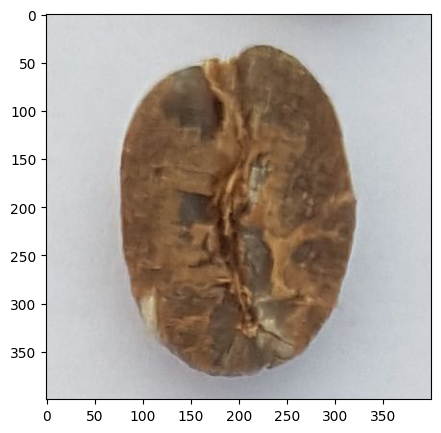

In [ ]:
# Visualizando a amostra a ser testada

sample = os.path.join(data_dir, 'good/Set04-good.01.05.jpg')
show_image(sample)

In [ ]:
# Realizando o teste usando o modelo treinado

test_image = Image.open(sample)

if device.type == 'cuda':
    test_image_tensor = data_transforms(test_image).to(device)
else:
    test_image_tensor = data_transforms(test_image).float()

test_image_tensor = test_image_tensor.unsqueeze_(0)
output = model_ft(test_image_tensor)
class_index = output.data.argmax()

In [ ]:
# Resultado

print(f'Classes: {full_dataset.class_to_idx}')
print(f'Identificou: {class_index}')

Classes: {'bad': 0, 'good': 1}
Identificou: 1
